In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_13022/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def create_results(filename):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(filename)
    
    return df

In [270]:
def plot_cyclegg_results(df):
    # Filter rows with "Valid" result
    valid_results = df[df['result'] == 'Valid']

    # Create time_range variable
    time_range = np.arange(0, 10.1 * 1000, 0.1 * 1000)  # Range from 0 to 300 seconds in 100ms increments
    
    # Initialize num_valid_at_time variable
    num_valid_at_time = []
    
    # Iterate over time_range and count the number of valid results for each time step
    for t in time_range:
        num_valid = valid_results[valid_results['time'] <= t].shape[0]
        num_valid_at_time.append(num_valid)



    # Creating subplots with a 2x1 grid
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # Plotting the data for the first 2 seconds
    ax1.plot(time_range, num_valid_at_time)
    ax1.set_xlim(0, 1000)  # Limiting x-axis to the first 2 seconds
    
    # Plotting the data for the rest of the time
    ax2.plot(time_range, num_valid_at_time)
    ax2.set_xlim(1000, 10000)  # Limiting x-axis to 2 to 60 seconds
    
    # Adjusting tick labels for the first subplot
    # ax1.set_xticks([i for i in range(0, 2001, 10)])  # Granularity of 0.01 seconds
    
    # Adding labels and title
    fig.text(0.5, 0.04, 'Time (s)', ha='center')
    fig.text(0.04, 0.5, 'Data', va='center', rotation='vertical')
    fig.suptitle('Data vs Time')
    
    # Adjusting layout to prevent overlap
    plt.tight_layout()
    
    # Displaying the plot
    plt.show()
    
    # Plot 1: time versus name for Valid results
    plt.figure(figsize=(8, 6))
    plt.plot(time_range, num_valid_at_time)
    # Zooming in on the first 2 seconds
    plt.gca().set_aspect(2/10)
    plt.xlabel('Time (ms)')
    plt.ylabel('Count')
    plt.title('Time versus count for Valid Results')
    plt.show()
    
    # Plot 2: num_lemmas_attempted versus name for all rows
    # plt.figure(figsize=(8, 6))
    # plt.scatter(df['name'],df['num_lemmas_attempted'])
    # plt.xlabel('Name')
    # plt.ylabel('Number of Lemmas Attempted')
    # plt.title('Number of Lemmas Attempted versus Name')
    # plt.gca().axes.get_xaxis().set_visible(False)  # Hide the name axis
    # plt.show()

In [271]:
def zoomed_in_cactus_plot(filtered_times, tool_names, title, end_zoom_range=1, zoom_scale=0.002, end_range=10, regular_scale=0.01):
    '''
    Takes in a list of times
    and makes a cactus plot for them which is zoomed in on 1s.
    '''
    
    # Generate times
    times_first_segment = np.arange(0, end_zoom_range, zoom_scale)
    times_second_segment = np.arange(end_zoom_range, end_range, regular_scale)
    times = np.concatenate((times_first_segment, times_second_segment))
    
    # Iterate over time_range and count the number of valid results for each time step
    for i, time_data in enumerate(filtered_times):
        num_valid_at_time = []
        for t in times:
            num_valid = time_data[time_data <= t].shape[0]
            num_valid_at_time.append(num_valid)
        plt.plot(range(len(num_valid_at_time)), num_valid_at_time, label = tool_names[i])

    # print(list(zip(times, num_valid_at_time)))
    # print([f'{times[i]}ms' for i in range(0, len(times), len(times) // 10)])
    
    # Plot
    plt.xlabel('Time (s)')
    plt.ylabel('# Benchmarks')
    plt.xticks(ticks=np.arange(0, len(times), len(times) // 10), labels=[f'{times[i]:.1f}s' for i in range(0, len(times), len(times) // 10)])

    # Add vertical line at the point where the time scale changes
    plt.axvline(len(times_first_segment), color='gray', linestyle='--')
    
    # Annotate the plot to indicate the transition
    plt.annotate('Time scale changes', xy=(len(times_first_segment), 0), xytext=(len(times_first_segment) + 100, 0.5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.legend()
    plt.title(title)
    plt.show()

In [5]:
def cactus_plot(filtered_times, tool_names, title, end_range=10, scale=0.01):
    '''
    Takes in a list of times
    and makes a cactus plot for them which is zoomed in on 1s.
    '''
    
    # Generate times
    times = np.arange(0, end_range, scale)
    
    # Iterate over time_range and count the number of valid results for each time step
    for i, time_data in enumerate(filtered_times):
        num_valid_at_time = []
        for t in times:
            num_valid = time_data[time_data <= t].shape[0]
            num_valid_at_time.append(num_valid)
        plt.plot(times, num_valid_at_time, label = tool_names[i])

    # print(list(zip(times, num_valid_at_time)))
    # print([f'{times[i]}ms' for i in range(0, len(times), len(times) // 10)])
    
    # Plot
    plt.xlabel('Time')
    plt.ylabel('# Benchmarks')
    plt.legend()
    plt.title(title)
    plt.show()

In [6]:
def filter_clam_results(clam_results, name_column, name_prefix, results_to_keep, name_suffix='', ignore_missing=False):
    '''
    Filters a dataframe containing clam results to only those
    that require lemmas.
    '''
    # Create a new list result_names by prepending name_prefix to results_to_keep
    result_names = [name_prefix + str(result) + name_suffix for result in results_to_keep]

    # Filter clam_results to keep only results where name_column is contained in results_to_keep
    filtered_results = clam_results[clam_results[name_column].isin(result_names)]

    # for result in result_names:
    #     if not any(result == clam_results[name_column]):
    #         print(result)
    if not ignore_missing:
        assert(len(filtered_results) == 50)

    return filtered_results

In [195]:
def plot_scatter(results_1, results_2, tool_1, tool_2, dataset, result_1_limit=None, result_2_limit=None, axis='time', extra_title='', plot_log=False):
    if result_1_limit is None:
        result_1_limit = results_1[axis].max()
        if plot_log:
            result_1_limit = np.log10(result_1_limit)
    if result_2_limit is None:
        result_2_limit = results_2[axis].max()
        if plot_log:
            result_2_limit = np.log10(result_2_limit)
    
    # Assuming results_1 and results_2 are your DataFrames
    # Merge the DataFrames on 'name' column
    merged_df = results_1.merge(results_2, on='name', suffixes=('_1', '_2'))
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    
    # Define marker styles and colors based on result column
    marker_styles = {
        (False, False): {'marker': '+', 'color': 'blue'},   # Both False
        (True, False): {'marker': '*', 'color': 'green'},   # results_1 True, results_2 False
        (False, True): {'marker': 'x', 'color': 'red'},     # results_1 False, results_2 True
        (True, True): {'marker': 'o', 'color': 'black'}        # All other cases
    }
    
    for index, row in merged_df.iterrows():
        result_1 = row['result_1']
        result_2 = row['result_2']
        count_1 = row[axis + '_1']
        count_2 = row[axis + '_2']
        if plot_log:
            # add 1 to prevent div by 0
            count_1 = np.log10(count_1 + 1)
            count_2 = np.log10(count_2 + 1)
        marker_style = marker_styles[(result_1, result_2)]
        plt.scatter(count_1, count_2, marker=marker_style['marker'], color=marker_style['color'], label=f"Result: {result_1}, {result_2}")

    plt.xlim(0, result_1_limit)
    plt.ylim(0, result_2_limit)
    # Add labels and legend
    plt.xlabel(f'{axis} in {tool_1}' + (' (log)' if plot_log else ''))
    plt.ylabel(f'{axis} in {tool_2}' + (' (log)' if plot_log else ''))
    plt.title(f'Scatter Plot of {axis}^2 {tool_1} vs {tool_2} in {dataset}' + (f' ({extra_title})' if extra_title else ''))

    # Adding a dashed diagonal line
    plt.plot([0, result_1_limit], [0, result_2_limit], 'k--')
    
    # Adding legend with custom markers and colors
    legend_handles = []
    prove_result_to_str = lambda res: 'Proves' if res else 'Fails'
    for (result_1, result_2), label in marker_styles.items():
        legend_handles.append(plt.Line2D([0], [0], marker=label['marker'], color=label['color'],
                                         label=f"{tool_1} {prove_result_to_str(result_1)}, {tool_2} {prove_result_to_str(result_2)}"))
    plt.legend(handles=legend_handles)
    
    # Show plot
    plt.grid(True)
    plt.show()

In [258]:
def plot_scatter2(results_1, results_2, tool_1, tool_2, dataset, result_1_limit=None, result_2_limit=None, axis='time', extra_title='', plot_log=False):
    if result_1_limit is None:
        result_1_limit = results_1[axis].max()
        if plot_log:
            result_1_limit = np.log10(result_1_limit)
    if result_2_limit is None:
        result_2_limit = results_2[axis].max()
        if plot_log:
            result_2_limit = np.log10(result_2_limit)
    
    # Assuming results_1 and results_2 are your DataFrames
    # Merge the DataFrames on 'name' column
    merged_df = results_1.merge(results_2, on='name', suffixes=('_1', '_2'))
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    
    # Define marker styles and colors based on result column
    marker_styles = {
        (False, 'sufu'): {'marker': '+', 'color': 'blue'},   # Both False
        (True, 'sufu'): {'marker': '*', 'color': 'green'},   # results_1 True, results_2 False
        (False, 'clam'): {'marker': 'x', 'color': 'red'},     # results_1 False, results_2 True
        (True, 'clam'): {'marker': 'o', 'color': 'black'}        # All other cases
    }
    
    for index, row in merged_df.iterrows():
        result_1 = row['result_1']
        assert(row['dataset_1'] == row['dataset_2'])
        result_2 = row['dataset_1']
        count_1 = row[axis + '_1']
        count_2 = row[axis + '_2']
        if plot_log:
            # add 1 to prevent div by 0
            count_1 = np.log10(count_1 + 1)
            count_2 = np.log10(count_2 + 1)
        marker_style = marker_styles[(result_1, result_2)]
        plt.scatter(count_1, count_2, marker=marker_style['marker'], color=marker_style['color'], label=f"Result: {result_1}, {result_2}")

    plt.xlim(0, result_1_limit)
    plt.ylim(0, result_2_limit)
    # Add labels and legend
    plt.xlabel(f'{axis} in {tool_1}' + (' (log)' if plot_log else ''))
    plt.ylabel(f'{axis} in {tool_2}' + (' (log)' if plot_log else ''))
    plt.title(f'Scatter Plot of {axis}^2 {tool_1} vs {tool_2} in {dataset}' + (f' ({extra_title})' if extra_title else ''))

    # Adding a dashed diagonal line
    plt.plot([0, result_1_limit], [0, result_2_limit], 'k--')
    
    # Adding legend with custom markers and colors
    legend_handles = []
    prove_result_to_str = lambda res: 'Proves' if res else 'Fails'
    for (result_1, result_2), label in marker_styles.items():
        legend_handles.append(plt.Line2D([0], [0], marker=label['marker'], color=label['color'],
                                         label=f"{tool_1} {prove_result_to_str(result_1)} ({result_2})"))
    plt.legend(handles=legend_handles)
    
    # Show plot
    plt.grid(True)
    plt.show()

In [8]:
def cyclegg_valid_times(cyclegg_df):
    return cyclegg_df[cyclegg_df['result'] == 'Valid']['time'] / 1000

In [9]:
def hipspec_valid_times(hipspec_df):
    return hipspec_df[hipspec_df['prop_proven']]['time']

In [10]:
def thesy_valid_times(thesy_df):
    return thesy_df[thesy_df['success']]['time']

In [11]:
def cvc4_valid_times(cvc4_df):
    return cvc4_df[cvc4_df['result'] == 'success']['time'].map(lambda t: float(t.rstrip(' ms')) / 1000)

In [12]:
def normalized_df_valid_times(df):
    return df[df['result']]['time']

In [13]:
def cyclegg_normalize_df(cyclegg_df, prefix):
    norm_df = cyclegg_df.copy()
    norm_df['name'] = cyclegg_df['name'].str[len(prefix):].str.removeprefix('0')
    norm_df['result'] = cyclegg_df['result'] == 'Valid'
    norm_df['time'] = cyclegg_df['time'] / 1000
    return norm_df

In [14]:
def hipspec_normalize_df(hipspec_df, prefix='./'):
    norm_df = hipspec_df.copy()
    # remove leading 0s as well as the prefix
    norm_df['name'] = hipspec_df['prop_name'].str[len(prefix):].str.lstrip('0')
    norm_df['result'] = hipspec_df['prop_proven']
    # num_lemmas already exists but it isn't the same
    norm_df['num_lemmas'] = hipspec_df['num_lemmas_attempted']
    norm_df['num_lemmas_proven'] = hipspec_df['num_proved_lemmas']
    return norm_df

In [15]:
def thesy_normalize_df(thesy_df, prefix='goal', suffix='.smt2.stats.json'):
    norm_df = thesy_df.copy()
    # remove prefix/suffix
    norm_df['name'] = thesy_df['file_name'].str[len(prefix):].str.removesuffix(suffix)
    norm_df['result'] = thesy_df['success']
    # not available
    norm_df['num_lemmas'] = -1
    norm_df['num_lemmas_proven'] = thesy_df['lemma_count']
    return norm_df

In [16]:
def cvc4_normalize_df(cvc4_df, prefix='goal', suffix='.smt2'):
    norm_df = cvc4_df.copy()
    # remove prefix/suffix
    norm_df['name'] = cvc4_df['name'].str[len(prefix):].str.removesuffix(suffix)
    norm_df['result'] = cvc4_df['result'] == 'success'
    norm_df['time'] = cvc4_df['time'].map(lambda t: float(t.rstrip(' ms')) / 1000)
    # not available
    norm_df['num_lemmas'] = -1
    norm_df['num_lemmas_proven'] = -1
    return norm_df

In [165]:
def make_clam_lemma_props():
    # Range from 1 to 35 inclusive
    range1 = map(str, range(1, 36))
    # Handle the case where there's a prefix 0 (hacky, I know)
    range_single_digit = map(lambda x: '0' + str(x), range(1,10))
    # Range from 48 to 50 inclusive
    range2 = map(str, range(48, 51))
    # Range from 75 to 86 inclusive
    range3 = map(str, range(75, 87))
    
    # Combine all ranges
    clam_lemma_props = list(range_single_digit) + list(range1) + list(range2) + list(range3)
    return clam_lemma_props

In [166]:
clam_lemma_props = make_clam_lemma_props()
len(clam_lemma_props)

59

In [18]:
cyclegg_results_clam = create_results("./goto-cyclegg-clam.csv")
cyclegg_results_clam_lemma_props = filter_clam_results(cyclegg_results_clam, 'name', 'clam_', clam_lemma_props)
# time data for the props which were valid among the lemma props
cyclegg_clam_props_valid_times = cyclegg_valid_times(cyclegg_results_clam_lemma_props)
print(len(cyclegg_clam_props_valid_times))

38


In [19]:
hipspec_results_clam = create_results("./hipspec-results-clam.csv")
hipspec_results_clam_lemma_props = filter_clam_results(hipspec_results_clam, 'prop_name', './', clam_lemma_props)
hipspec_clam_lemma_props_valid_times = hipspec_valid_times(hipspec_results_clam_lemma_props)
len(hipspec_clam_lemma_props_valid_times)

41

In [298]:
thesy_results = create_results("./goto-2-27/thesy-no-expl-proofs.csv")
thesy_results_clam = thesy_results[thesy_results['test_suite'] == 'clam_trimmed']
thesy_results_clam_lemma_props = filter_clam_results(thesy_results_clam, 'file_name', 'goal', clam_lemma_props, name_suffix='.smt2.stats.json', ignore_missing=True)
thesy_clam_lemma_props_valid_times = thesy_valid_times(thesy_results_clam_lemma_props)
len(thesy_clam_lemma_props_valid_times)

35

In [21]:
cvc4_results_clam = create_results("./cvc4-ig-results-clam.csv")
cvc4_results_clam_lemma_props = filter_clam_results(cvc4_results_clam, 'name', 'goal', clam_lemma_props, name_suffix='.smt2')
cvc4_clam_lemma_props_valid_times = cvc4_valid_times(cvc4_results_clam_lemma_props)

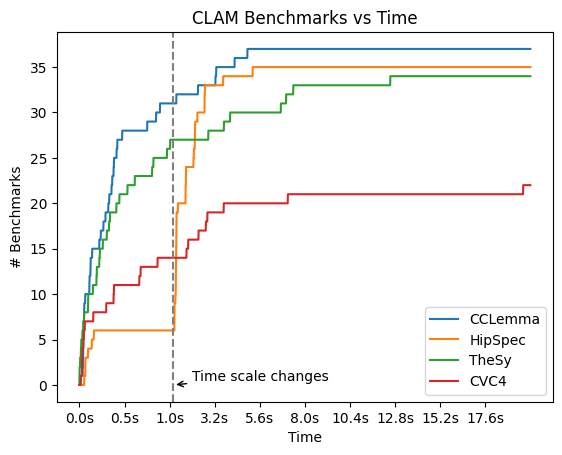

In [22]:
zoomed_in_cactus_plot([cyclegg_clam_props_valid_times, hipspec_clam_lemma_props_valid_times, thesy_clam_lemma_props_valid_times, cvc4_clam_lemma_props_valid_times],
                      ['CCLemma', 'HipSpec', 'TheSy', 'CVC4'],
                      'CLAM Benchmarks vs Time', end_range=20)

In [23]:
cyclegg_results_isa = create_results("./goto-cyclegg-isa.csv")
cyclegg_isa_valid_times = cyclegg_valid_times(cyclegg_results_isa)

In [24]:
hipspec_results_isa = create_results("./hipspec-results-isaplanner.csv")
hipspec_isa_valid_times = hipspec_valid_times(hipspec_results_isa)
len(hipspec_isa_valid_times)

76

In [299]:
thesy_results_isa = thesy_results[thesy_results['test_suite'] == 'isaplanner']
thesy_isa_valid_times = thesy_valid_times(thesy_results_isa)
len(thesy_isa_valid_times)

45

In [26]:
cvc4_results_isa = create_results("./cvc4-ig-results-isaplanner.csv")
cvc4_isa_valid_times = cvc4_valid_times(cvc4_results_isa)

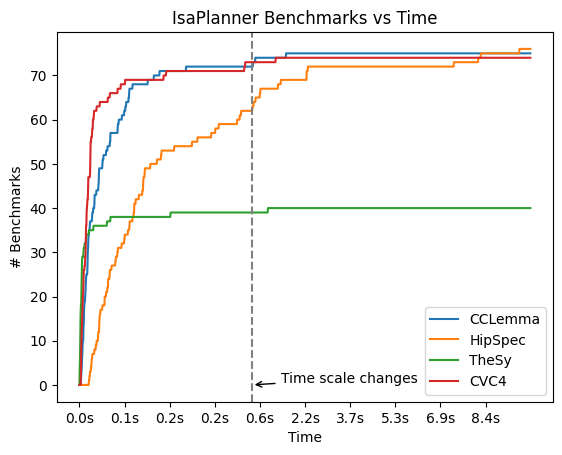

In [27]:
zoomed_in_cactus_plot([cyclegg_isa_valid_times, hipspec_isa_valid_times, thesy_isa_valid_times, cvc4_isa_valid_times],
                      ['CCLemma', 'HipSpec', 'TheSy', 'CVC4'],
                      'IsaPlanner Benchmarks vs Time',
                      end_zoom_range=0.3, zoom_scale=0.0005, end_range=10)

In [28]:
cyclegg_results_sufu = cyclegg_normalize_df(create_results('goto-cyclegg-sufu.csv'),'')
cyclegg_sufu_valid_times = normalized_df_valid_times(cyclegg_results_sufu)
len(cyclegg_sufu_valid_times)

27

In [29]:
cvc4_results_sufu = create_results('goto-cvc4-ig-results-sufu.csv')
cvc4_results_sufu['name'] = cvc4_results_sufu['name'].str.removeprefix('cvc4-sufu/')
cvc4_sufu_valid_times = normalized_df_valid_times(cvc4_results_sufu)
len(cvc4_sufu_valid_times)

19

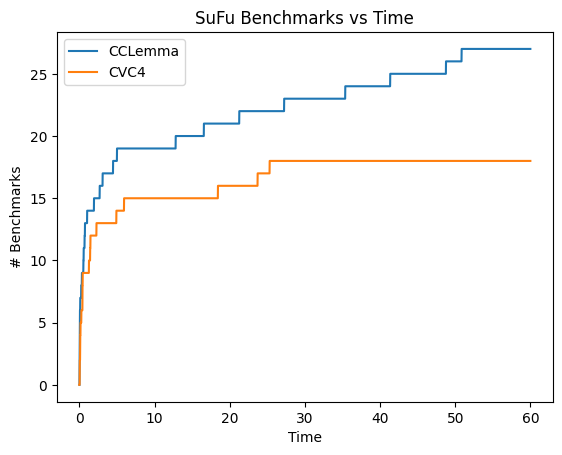

In [30]:
cactus_plot([cyclegg_sufu_valid_times, cvc4_sufu_valid_times],
                      ['CCLemma', 'CVC4'],
                      'SuFu Benchmarks vs Time',
                      end_range=60)

In [31]:
cyclegg_results_clam_lemma_props_norm = cyclegg_normalize_df(cyclegg_results_clam_lemma_props, 'clam_')
# cyclegg_results_clam_lemma_props_norm

In [32]:
hipspec_results_clam_lemma_props_norm = hipspec_normalize_df(hipspec_results_clam_lemma_props)

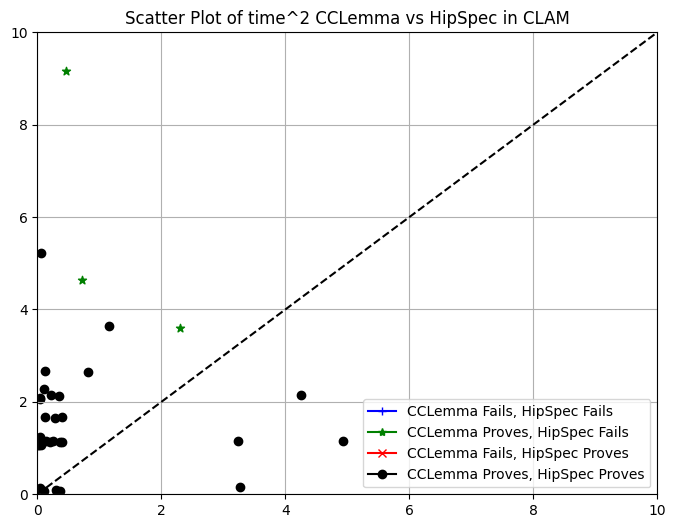

In [33]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 'CLAM', 10, 10)

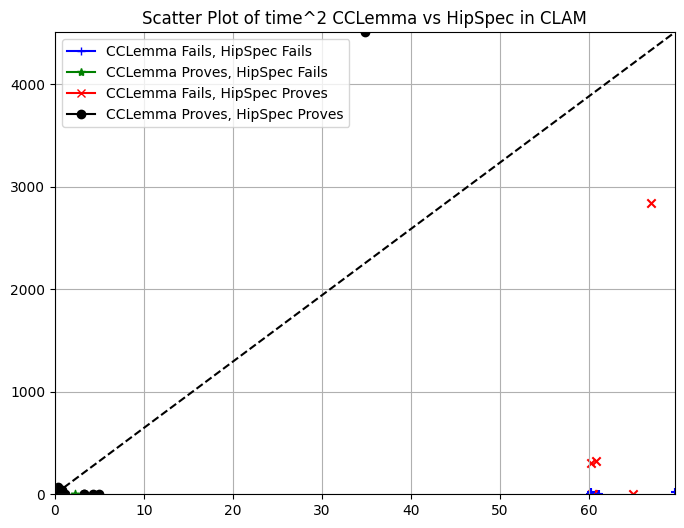

In [34]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 'CLAM')

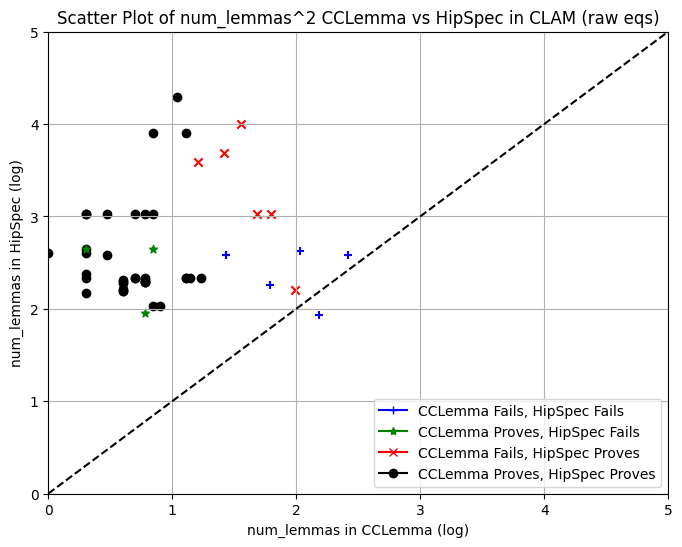

In [35]:
hipspec_clam_lemma_props_norm_raw_eqs = hipspec_results_clam_lemma_props_norm.copy()
hipspec_clam_lemma_props_norm_raw_eqs['num_lemmas'] = hipspec_results_clam_lemma_props_norm['num_raw_eqs']
hipspec_clam_lemma_props_norm_evals = hipspec_results_clam_lemma_props_norm.copy()
hipspec_clam_lemma_props_norm_evals['num_lemmas'] = hipspec_results_clam_lemma_props_norm['num_evals']
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_clam_lemma_props_norm_raw_eqs, 'CCLemma', 'HipSpec',
             'CLAM', 5, 5,
             axis='num_lemmas', extra_title='raw eqs', plot_log=True)

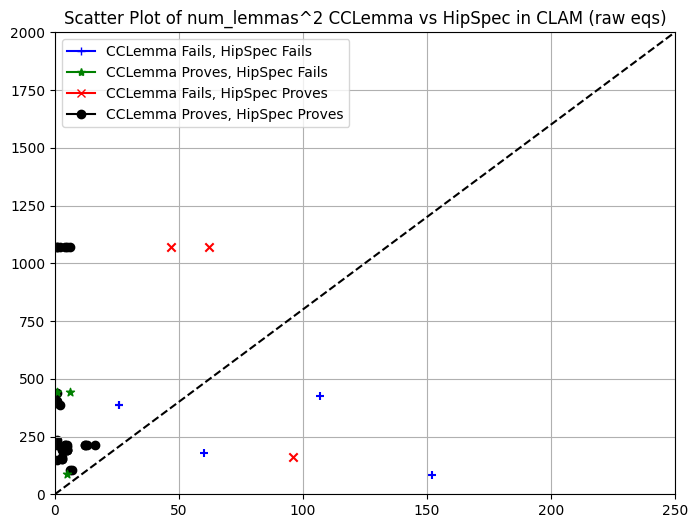

In [36]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_clam_lemma_props_norm_raw_eqs, 'CCLemma', 'HipSpec', 'CLAM',
             250, 2000, axis='num_lemmas', extra_title='raw eqs')

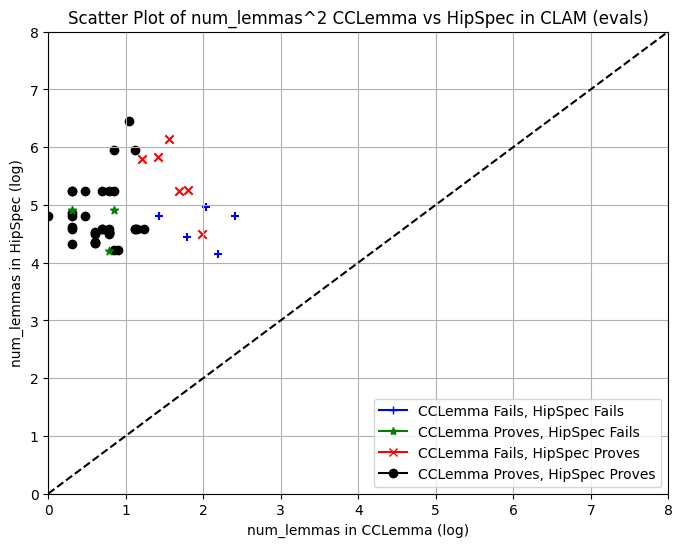

In [37]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_clam_lemma_props_norm_evals, 'CCLemma', 'HipSpec', 'CLAM',
             8, 8,
             axis='num_lemmas', extra_title='evals', plot_log=True)

In [38]:
# Assuming dfs is a list of your pandas dataframes
# with columns 'name', 'time', and 'result'

# Example list of dataframes (replace this with your actual list)
data1 = {'name': ['A', 'B', 'C', 'D', 'E'],
         'time': [10, 15, 20, 25, 30],
         'result': [True, False, True, False, True]}

data2 = {'name': ['A', 'B', 'C', 'D', 'E'],
         'time': [12, 18, 22, 26, 32],
         'result': [True, True, False, True, False]}

data3 = {'name': ['A', 'B', 'C', 'D', 'E'],
         'time': [8, 16, 21, 24, 31],
         'result': [True, False, True, True, True]}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

dfs = [('one', df1), ('two', df2), ('three', df3)]

# Define a function to compute the comparison table
def make_comparison_table(*dfs, time_cutoff=None):
    comparison_data = []

    # Compute comparison data for each dataframe
    for i, (name, d) in enumerate(dfs):
        # the first dataframe is our anchor
        if i == 0:
            base_df = d.copy()
            if time_cutoff:
                base_df = base_df[base_df['time'] <= time_cutoff]
            base_count = base_df['result'].sum()
            count = base_count
            avg_time = base_df[base_df['result']]['time'].mean()
            median_time = base_df[base_df['result']]['time'].median()
            max_time = base_df[base_df['result']]['time'].max()
            # "time out" the results that are out of time,
            # but don't filter them
            if time_cutoff:
                base_df = d.copy()
                base_df.loc[base_df['time'] > time_cutoff, 'result'] = False
            can_prove = []
            num_can_prove = 0
            cant_prove = []
            num_cant_prove = 0
        else:
            df = d.copy()
            if time_cutoff:
                df = d[d['time'] <= time_cutoff]
            count = df['result'].sum()
            avg_time = df[df['result']]['time'].mean()
            median_time = df[df['result']]['time'].median()
            max_time = df[df['result']]['time'].max()
            # "time out" the results that are out of time,
            # but don't filter them
            if time_cutoff:
                df = d.copy()
                df.loc[df['time'] > time_cutoff,'result'] = False
            # Merge the two dataframes on the 'name' column
            merged_df = base_df.merge(df, on='name', suffixes=('_1', '_2'), how='left', validate='one_to_one')
            merged_df['result_1'] = merged_df['result_1'].fillna(False)
            merged_df['result_2'] = merged_df['result_2'].fillna(False)
            can_prove = merged_df[~merged_df['result_1'] & merged_df['result_2']]['name'].tolist()
            num_can_prove = len(can_prove)
            cant_prove = merged_df[merged_df['result_1'] & ~merged_df['result_2']]['name'].tolist()
            num_cant_prove = len(cant_prove)
            if count + (num_cant_prove - num_can_prove) != base_count:
                print(f'WARN: num_cant_proe - num_can_prove = {num_cant_prove - num_can_prove} is not base_count - count {base_count - count}')

        comparison_data.append({
            'name': name,
            'count': count,
            'avg_time': avg_time,
            'median_time': median_time,
            'max_time': max_time,
            'can_prove': can_prove,
            'num_can_prove': num_can_prove,
            'cant_prove': cant_prove,
            'num_cant_prove': num_cant_prove,
        })

    comparison_table = pd.DataFrame(comparison_data)
    return comparison_table

# Call the function to get the comparison table
comparison_table = make_comparison_table(*dfs)
comparison_table

,name,count,avg_time,median_time,max_time,can_prove,num_can_prove,cant_prove,num_cant_prove
0,one,3,20.000000,20.0,30,[],0,[],0
1,two,3,18.666667,18.0,26,"[B, D]",2,"[C, E]",2
2,three,4,21.000000,22.5,31,[D],1,[],0


In [265]:
def table_to_latex(table):
    header = r'''\begin{tabular}{l l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
'''
    body = ''
    for _, row in table.iterrows():
        body += f"& {row['name']} & {row['count']} & {row['median_time']:.2f} & {row['max_time']:.2f} & {row['num_can_prove']} & {row['num_cant_prove']}\\\\ \n"
    footer = '''\end{tabular}'''
    return header + body + footer

In [40]:
thesy_results_clam_lemma_props_norm = thesy_normalize_df(thesy_results_clam_lemma_props)
cvc4_results_clam_lemma_props_norm = cvc4_normalize_df(cvc4_results_clam_lemma_props)

In [41]:
cyclegg_results_isa_norm = cyclegg_normalize_df(cyclegg_results_isa,'goal_')
thesy_results_isa_norm = thesy_normalize_df(thesy_results_isa)
cvc4_results_isa_norm = cvc4_normalize_df(cvc4_results_isa)
hipspec_results_isa_norm = hipspec_normalize_df(hipspec_results_isa)

In [42]:
isa_table = make_comparison_table(('CCLemma', cyclegg_results_isa_norm),
                      ('CVC4', cvc4_results_isa_norm),
                      ('HipSpec', hipspec_results_isa_norm),
                      ('TheSy', thesy_results_isa_norm),
                                 time_cutoff=60)
isa_table

/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)


,name,count,avg_time,median_time,max_time,can_prove,num_can_prove,cant_prove,num_cant_prove
0,CCLemma,75,0.063301,0.021890,1.483084,[],0,[],0
1,CVC4,74,0.041409,0.012120,1.123430,"[53, 85]",2,"[54, 66, 70]",3
2,HipSpec,76,0.663005,0.093165,9.609504,"[74, 75, 76, 85]",4,"[20, 50, 83]",3
3,TheSy,43,1.670677,0.003454,32.911831,[85],1,"[3, 21, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36...",33


In [43]:
clam_table = make_comparison_table(('CCLemma', cyclegg_results_clam_lemma_props_norm),
                      ('CVC4', cvc4_results_clam_lemma_props_norm),
                      ('HipSpec', hipspec_results_clam_lemma_props_norm),
                      ('TheSy', thesy_results_clam_lemma_props_norm),
                                  time_cutoff=60)
clam_table

/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)


,name,count,avg_time,median_time,max_time,can_prove,num_can_prove,cant_prove,num_cant_prove
0,CCLemma,38,1.623295,0.291811,34.861555,[],0,[],0
1,CVC4,23,2.859664,0.636100,20.527100,"[21, 33, 83, 84]",4,"[1, 4, 6, 10, 11, 13, 15, 16, 17, 18, 19, 20, ...",19
2,HipSpec,36,2.638918,1.159143,42.327415,"[29, 31, 78]",3,"[28, 34, 35, 48, 76]",5
3,TheSy,35,2.058328,0.315560,20.029345,"[21, 29, 31, 32, 49, 78, 83, 84]",8,"[2, 4, 5, 8, 9, 20, 22, 23, 34, 35, 75]",11


In [44]:
sufu_table = make_comparison_table(('CCLemma', cyclegg_results_sufu),
                      ('CVC4', cvc4_results_sufu),
                                  time_cutoff=60)
sufu_table

/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)


,name,count,avg_time,median_time,max_time,can_prove,num_can_prove,cant_prove,num_cant_prove
0,CCLemma,27,10.205828,1.016150,50.836496,[],0,[],0
1,CVC4,18,4.803873,0.840512,25.297654,"[autolifter-single-pass-dropwhile, synduce-tre...",5,"[synduce-tree-sumtree, synduce-indexed_list-se...",14


In [45]:
print(table_to_latex(isa_table))

\begin{tabular}{l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
CCLemma & 75 & 0.02 & 1.48 & 0 & 0\\ 
CVC4 & 74 & 0.01 & 1.12 & 2 & 3\\ 
HipSpec & 76 & 0.09 & 9.61 & 4 & 3\\ 
TheSy & 43 & 0.00 & 32.91 & 1 & 33\\ 
\end{tabular}


In [46]:
print(table_to_latex(clam_table))

\begin{tabular}{l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
CCLemma & 38 & 0.29 & 34.86 & 0 & 0\\ 
CVC4 & 23 & 0.64 & 20.53 & 4 & 19\\ 
HipSpec & 36 & 1.16 & 42.33 & 3 & 5\\ 
TheSy & 35 & 0.32 & 20.03 & 8 & 11\\ 
\end{tabular}


In [47]:
print(table_to_latex(sufu_table))

\begin{tabular}{l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
CCLemma & 27 & 1.02 & 50.84 & 0 & 0\\ 
CVC4 & 18 & 0.84 & 25.30 & 5 & 14\\ 
\end{tabular}


In [48]:
86 - len(hipspec_results_clam)

24

In [49]:
hipspec_results_clam[hipspec_results_clam['time'] < 300]['prop_proven'].sum()

47

In [118]:
def read_goto_cvc4(filename, prefix='goal'):
    df = pd.read_csv(filename)
    fix_name = lambda s: s.split('/')[-1].removeprefix(prefix).lstrip('0')
    df['name'] = df['name'].apply(fix_name)
    # sub any default values
    df.loc[df['result'] == False, 'time'] = df.loc[df['result'] == False, 'time'].replace(0.0, 60)
    return df

In [119]:
def read_goto_cyclegg(filename, prefix):
    df = pd.read_csv(filename)
    fix_name = lambda s: s.removeprefix(prefix).lstrip('0')
    df['name'] = df['name'].apply(fix_name)
    df['time'] = df['time'] / 1000
    df['result'] = df['result'] == 'Valid'
    df.loc[df['result'] == False, 'time'] = df.loc[df['result'] == False, 'time'].replace(0.0, 60)
    return df

In [120]:
def read_goto_hipspec(filename, prefix='prop_'):
    df = pd.read_csv(filename)
    fix_name = lambda s: s.split('/')[-1].removeprefix(prefix).lstrip('0')
    df['name'] = df['prop_name'].apply(fix_name)
    df['result'] = df['prop_proven']
    df.loc[df['result'] == False, 'time'] = df.loc[df['result'] == False, 'time'].replace(0.0, 60)
    return df

In [72]:
def names_not_in_intersection(*dataframes):
    # Extract 'name' columns from all DataFrames
    name_sets = [set(df['name']) for df in dataframes]
    
    # Find the intersection of all 'name' sets
    intersection = set.intersection(*name_sets)
    
    # Find names not in the intersection
    names_not_in_intersection = set.union(*[name_set - intersection for name_set in name_sets])
    
    return names_not_in_intersection

In [272]:
def cactus(dir, dataset, thesy_res, cyclegg_prefix, end_range=20, no_zoom=False):
    cvc4_res = read_goto_cvc4(dir + '/cvc4/' + dataset.lower() + '.csv')
    cyclegg_res = read_goto_cyclegg(dir + '/cclemma/' + dataset.lower() + '.csv', cyclegg_prefix)
    hipspec_res = read_goto_hipspec(dir + '/hipspec/' + dataset.lower() + '.csv')

    if dataset == 'clam':
        clam_lemma_props = make_clam_lemma_props()
        cvc4_res = filter_clam_results(cvc4_res, 'name', '', clam_lemma_props)
        cyclegg_res = filter_clam_results(cyclegg_res, 'name', '', clam_lemma_props)
        hipspec_res = filter_clam_results(hipspec_res, 'name', '', clam_lemma_props)
        thesy_res = filter_clam_results(thesy_res, 'name', '', clam_lemma_props, ignore_missing = True)


    tool_res = [('cclemma', cyclegg_res), ('hipspec', hipspec_res), ('cvc4', cvc4_res)]
    if thesy_res is not None:
        tool_res = tool_res + [('thesy', thesy_res)]

    missing_names = names_not_in_intersection(*[res for _, res in tool_res])
    for tool, res in tool_res:
        names = set(res['name'])
        if any(name not in names for name in missing_names):
            print(tool, f'is missing {len(missing_names - names)} entries')
            print(list(sorted(missing_names - names)))
            
    
    cvc4_valid_times = normalized_df_valid_times(cvc4_res)
    cyclegg_valid_times = normalized_df_valid_times(cyclegg_res)
    hipspec_valid_times = normalized_df_valid_times(hipspec_res)
    if thesy_res is not None:
        thesy_valid_times = normalized_df_valid_times(thesy_res)

    times = [cyclegg_valid_times, hipspec_valid_times, cvc4_valid_times]
    names = ['CCLemma', 'HipSpec', 'CVC4']
    if thesy_res is not None:
        times = times + [thesy_valid_times]
        names = names + ['TheSy']
    if no_zoom:
        cactus_plot(times,
                    names,
                    f'{dataset} Benchmarks vs Time',
                    end_range=end_range)
    else:
        zoomed_in_cactus_plot(times,
                              names,
                              f'{dataset} Benchmarks vs Time', end_range=end_range)
    
    return make_comparison_table(*tool_res)

In [292]:
thesy_results_sufu = thesy_results[thesy_results['test_suite'] == 'sufu']

thesy is missing 6 entries
['33', '34', '35', '8', '86', '9']


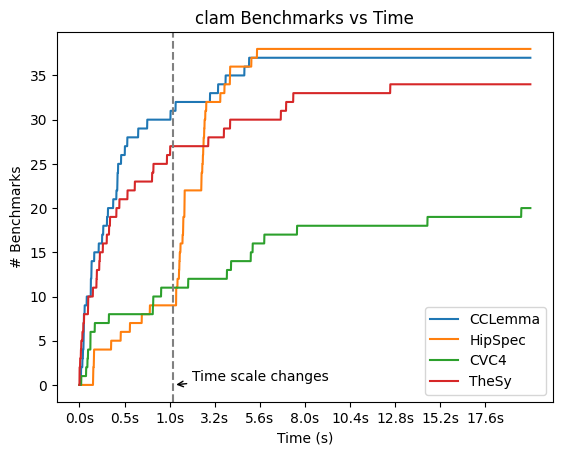

\begin{tabular}{l l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
& cclemma & 38 & 0.30 & 21.51 & 0 & 0\\ 
& hipspec & 38 & 1.55 & 5.44 & 6 & 6\\ 
& cvc4 & 22 & 1.33 & 41.63 & 3 & 19\\ 
& thesy & 35 & 0.32 & 20.03 & 8 & 11\\ 
\end{tabular}


/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)


In [274]:
table = cactus('goto-2-26', 'clam', thesy_normalize_df(thesy_results_clam), 'clam_')
print(table_to_latex(table))

thesy is missing 20 entries
['21', '3', '35', '36', '47', '50', '53', '55', '58', '59', '66', '70', '72', '73', '74', '76', '78', '83', '84', '87']


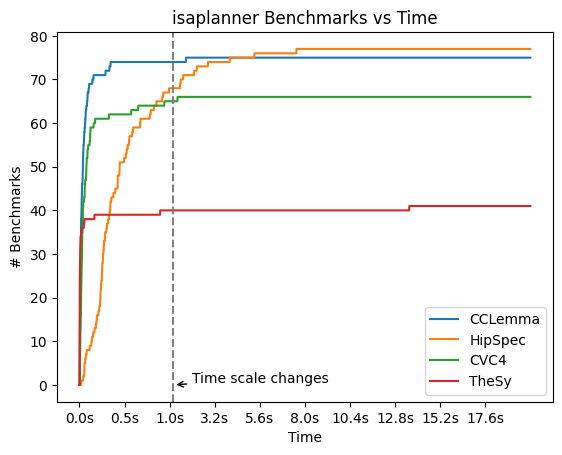

\begin{tabular}{l l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
& cclemma & 75 & 0.02 & 1.66 & 0 & 0\\ 
& hipspec & 77 & 0.32 & 7.55 & 4 & 2\\ 
& cvc4 & 67 & 0.03 & 57.86 & 3 & 11\\ 
& thesy & 45 & 0.00 & 67.45 & 1 & 31\\ 
\end{tabular}


/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)


In [268]:
table = cactus('goto-2-26', 'isaplanner', thesy_normalize_df(thesy_results_isa), 'goal_')
print(table_to_latex(table))

cclemma is missing 3 entries
['autolifter-single-pass-count10p', 'synduce-constraints-ensures-mps_no_ensures', 'synduce-list-mpshom']
hipspec is missing 19 entries
['fusion-algprog-page58', 'synduce-compressed_list-sum', 'synduce-constraints-alist-count_eq', 'synduce-constraints-alist-count_eq2', 'synduce-constraints-alist-sums', 'synduce-constraints-bst-check_included_comb', 'synduce-constraints-bst-check_mem_included', 'synduce-constraints-bst-most_frequent_v1', 'synduce-constraints-bst-sum_between', 'synduce-constraints-size-obfuscated_length', 'synduce-constraints-size-obfuscated_length_3', 'synduce-indexed_list-search', 'synduce-list-sumgt', 'synduce-list_to_tree-search', 'synduce-list_to_tree-search_v2', 'synduce-list_to_tree-search_v3', 'synduce-sorted_list-max', 'synduce-sorted_list-min', 'synduce-sorted_list-sumgtz']
cvc4 is missing 19 entries
['fusion-algprog-page58', 'synduce-compressed_list-sum', 'synduce-constraints-alist-count_eq', 'synduce-constraints-alist-count_eq2', '

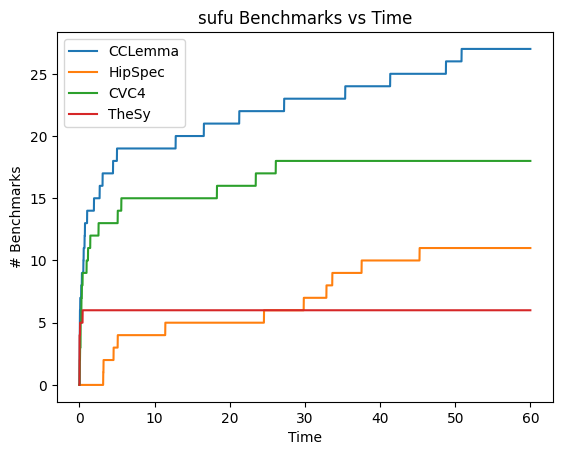

\begin{tabular}{l l r r r r r}
Tool & \# proved & Median time & Max time & \# we can't prove & \# they can't prove\\
\hline
& cclemma & 27 & 1.02 & 50.84 & 0 & 0\\ 
& hipspec & 11 & 24.55 & 45.24 & 0 & 16\\ 
& cvc4 & 18 & 0.68 & 26.12 & 5 & 14\\ 
& thesy & 6 & 0.01 & 0.42 & 0 & 21\\ 
\end{tabular}


/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)
/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['result_2'] = merged_df['result_2'].fillna(False)
/tmp/ipykernel_13022/2611914905.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

In [297]:
table = cactus('goto-2-26', 'sufu', thesy_normalize_df(thesy_results_sufu, suffix='.stats.json', prefix=''), '', end_range=60, no_zoom=True)
print(table_to_latex(table))

In [247]:
cyclegg_goto_clam = read_goto_cyclegg('goto-2-26/cclemma/clam.csv', 'clam_')
hipspec_goto_clam = read_goto_hipspec('goto-2-26/hipspec/clam.csv')
cyclegg_goto_clam = filter_clam_results(cyclegg_goto_clam, 'name', '', clam_lemma_props)
hipspec_goto_clam = filter_clam_results(hipspec_goto_clam, 'name', '', clam_lemma_props)

cyclegg_goto_clam['dataset'] = 'clam'
hipspec_goto_clam['dataset'] = 'clam'

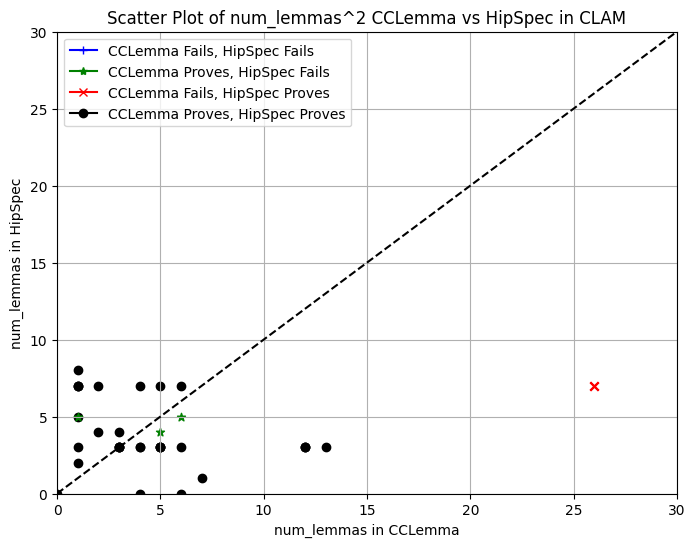

In [248]:
plot_scatter(cyclegg_goto_clam, hipspec_goto_clam, 'CCLemma', 'HipSpec', 'CLAM', 30, 30, axis='num_lemmas')

In [249]:
hipspec_goto_clam_raw_eqs = hipspec_goto_clam.copy()
hipspec_goto_clam_raw_eqs['num_lemmas'] = hipspec_goto_clam['num_raw_eqs']

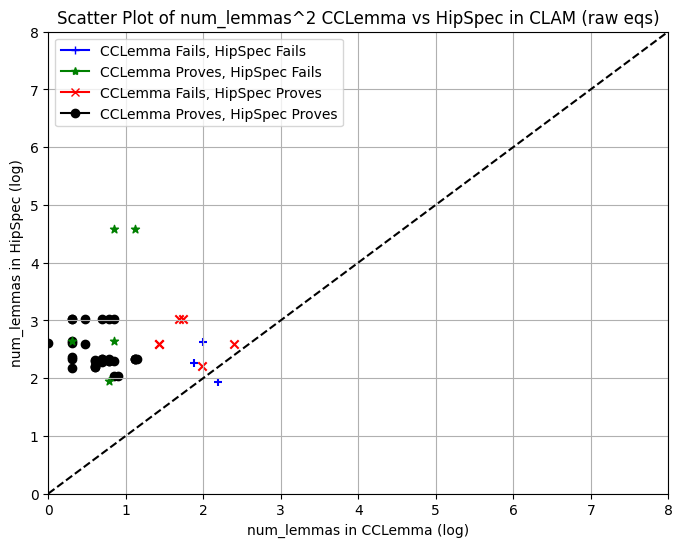

In [250]:
plot_scatter(cyclegg_goto_clam, hipspec_goto_clam_raw_eqs, 'CCLemma', 'HipSpec', 'CLAM', 8, 8, axis='num_lemmas', extra_title='raw eqs', plot_log=True)

In [251]:
hipspec_goto_clam_evals = hipspec_goto_clam.copy()
hipspec_goto_clam_evals['num_lemmas'] = hipspec_goto_clam['num_evals']

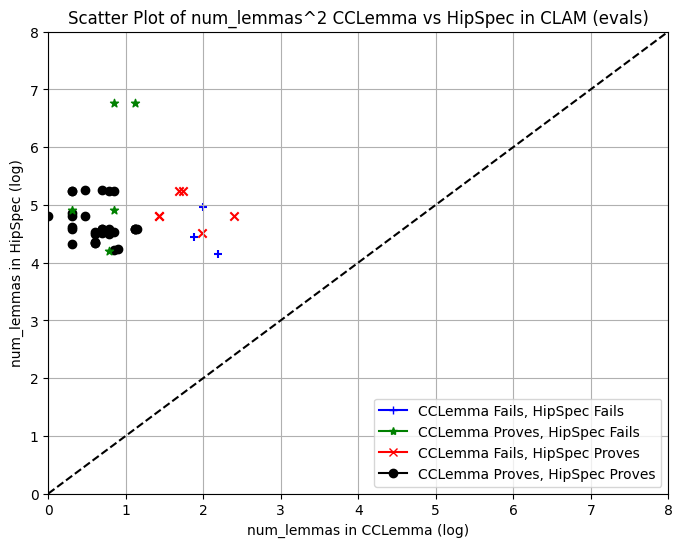

In [252]:
plot_scatter(cyclegg_goto_clam, hipspec_goto_clam_evals, 'CCLemma', 'HipSpec', 'CLAM', 8, 8, axis='num_lemmas', extra_title='evals', plot_log=True)

In [253]:
cyclegg_goto_sufu = read_goto_cyclegg('goto-2-26/cclemma/sufu.csv', '')
hipspec_goto_sufu = read_goto_hipspec('goto-2-26/hipspec/sufu.csv')

cyclegg_goto_sufu['dataset'] = 'sufu'
hipspec_goto_sufu['dataset'] = 'sufu'

hipspec_goto_sufu_raw_eqs = hipspec_goto_sufu.copy()
hipspec_goto_sufu_raw_eqs['num_lemmas'] = hipspec_goto_sufu['num_raw_eqs']
hipspec_goto_sufu_evals = hipspec_goto_sufu.copy()
hipspec_goto_sufu_evals['num_lemmas'] = hipspec_goto_sufu['num_evals']

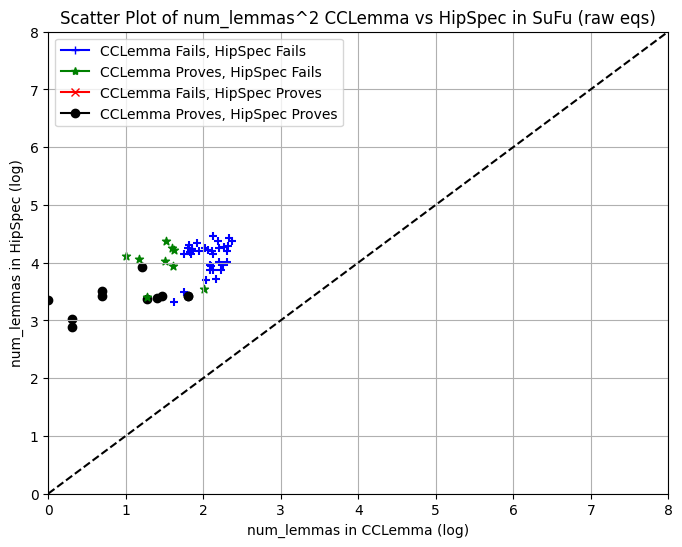

In [254]:
plot_scatter(cyclegg_goto_sufu, hipspec_goto_sufu_raw_eqs, 'CCLemma', 'HipSpec', 'SuFu', 8, 8, axis='num_lemmas', extra_title='raw eqs', plot_log=True)

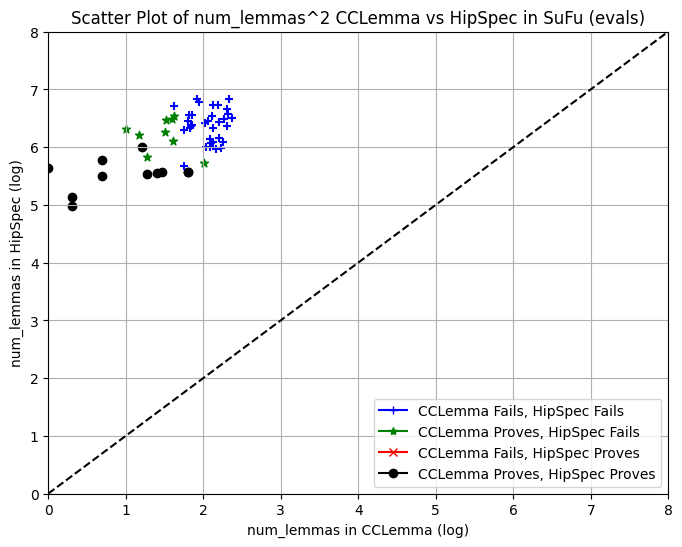

In [255]:
plot_scatter(cyclegg_goto_sufu, hipspec_goto_sufu_evals, 'CCLemma', 'HipSpec', 'SuFu', 8, 8, axis='num_lemmas', extra_title='evals', plot_log=True)

In [256]:
cyclegg_goto_cs = pd.concat([cyclegg_goto_clam, cyclegg_goto_sufu])
hipspec_goto_cs = pd.concat([hipspec_goto_clam, hipspec_goto_sufu])
hipspec_goto_cs_raw_eqs = pd.concat([hipspec_goto_clam_raw_eqs, hipspec_goto_sufu_raw_eqs])
hipspec_goto_cs_evals = pd.concat([hipspec_goto_clam_evals, hipspec_goto_sufu_evals])

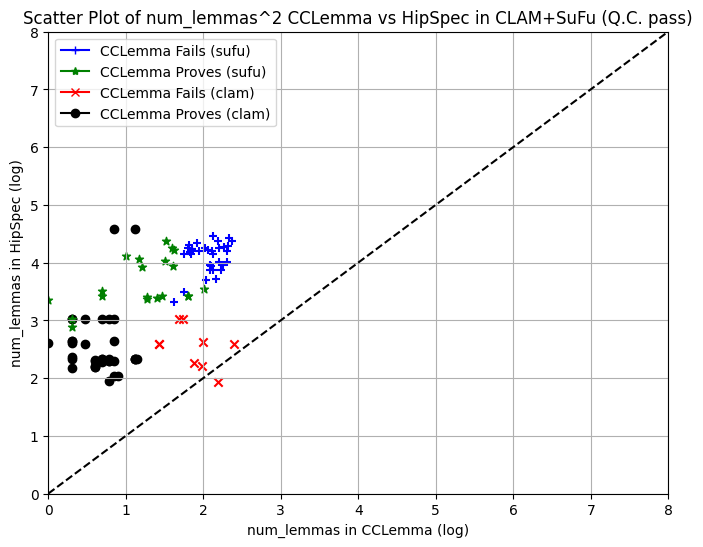

In [277]:
plot_scatter2(cyclegg_goto_cs, hipspec_goto_cs_raw_eqs, 'CCLemma', 'HipSpec', 'CLAM+SuFu', 8, 8, axis='num_lemmas', extra_title = 'Q.C. pass',plot_log=True)

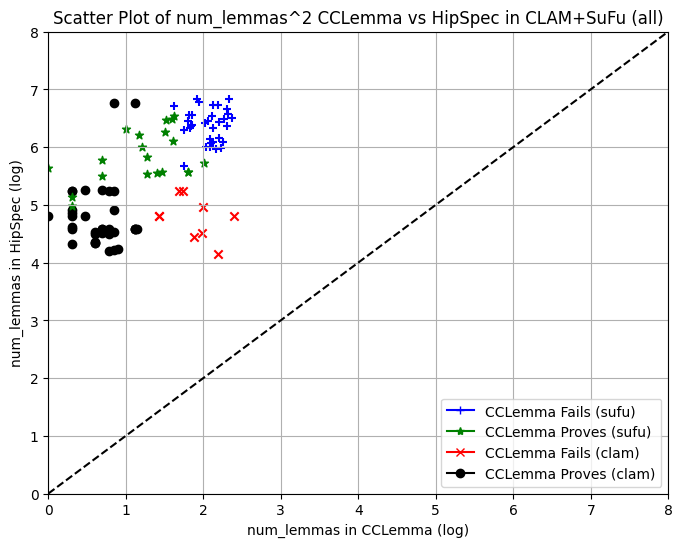

In [278]:
plot_scatter2(cyclegg_goto_cs, hipspec_goto_cs_evals, 'CCLemma', 'HipSpec', 'CLAM+SuFu', 8, 8, axis='num_lemmas', extra_title = 'all',plot_log=True)

In [279]:
cvc4_results_sufu[cvc4_results_sufu['result']]['name']

0                             synduce-tree-sorted
6                     autolifter-single-pass-0s1s
8            synduce-indexed_list-sum_elts_lt_pos
19               autolifter-single-pass-dropwhile
25        synduce-constraints-all_positive-sndmin
27                          fusion-shortcut-page1
36                     autolifter-single-pass-mps
41                        fusion-identities-page5
42                     autolifter-single-pass-sum
43                              synduce-list-last
45                       synduce-treepaths-height
46                     autolifter-single-pass-mts
47    synduce-constraints-empty_right_subtree-sum
48                synduce-treepaths-maxPathWeight
54                  autolifter-single-pass-length
72                        synduce-misc-simple_nnf
84              synduce-constraints-memo-constant
88                   fusion-deforestation-page7-2
93                 autolifter-single-pass-0after1
Name: name, dtype: object

In [280]:
cyclegg_results_sufu[cyclegg_results_sufu['result']]['name']

6                                   synduce-tree-sumtree
11                           synduce-indexed_list-search
19                         synduce-misc-unknowns_are_ids
25                         autolifter-single-pass-length
26                               fusion-identities-page5
40                               synduce-misc-simple_nnf
46                  synduce-indexed_list-sum_elts_lt_pos
47                            autolifter-single-pass-mps
51                          synduce-combine-mss_with_sum
53                                 fusion-shortcut-page1
54                            autolifter-single-pass-sum
56                               synduce-zipper-list_sum
58                                 fusion-algprog-page60
60     synduce-constraints-memo-proper_indexation_sum...
64                        autolifter-single-pass-0after1
70                           autolifter-single-pass-0s1s
74                                     synduce-list-last
76             synduce-constrai

In [282]:
cyclegg_clam_5s = read_goto_cyclegg('./local-cyclegg.csv', 'clam_')
cyclegg_clam_5s_no_grounding = read_goto_cyclegg('./local-cyclegg-no-grounding.csv', 'clam_')

make_comparison_table(('normal', cyclegg_clam_5s), ('no grounding', cyclegg_clam_5s_no_grounding))

,name,count,avg_time,median_time,max_time,can_prove,num_can_prove,cant_prove,num_cant_prove
0,normal,43,0.311249,0.086324,2.236311,[],0,[],0
1,no grounding,40,0.332714,0.082623,2.664073,[34],1,"[16, 20, 82, 85]",4


In [300]:
thesy_results

,test_suite,file_name,success,time,stop_reasons,lemma_count,failed_proof_count,proofs_later_filtered
0,isaplanner,goal1.smt2.stats.json,True,0.000867,[],0,0,0
1,isaplanner,goal10.smt2.stats.json,True,0.002040,[],0,0,0
2,isaplanner,goal11.smt2.stats.json,True,0.000262,[],0,0,0
3,isaplanner,goal12.smt2.stats.json,True,0.001176,[],0,0,0
4,isaplanner,goal13.smt2.stats.json,True,0.000789,[],0,0,0
...,...,...,...,...,...,...,...,...
236,clam_trimmed,goal81.smt2.stats.json,True,0.612674,"['IterationLimit', 'Saturated']",3,21,0
237,clam_trimmed,goal82.smt2.stats.json,True,0.903764,"['IterationLimit', 'Saturated']",4,19,2
238,clam_trimmed,goal83.smt2.stats.json,True,6.790350,['IterationLimit'],5,1,1
239,clam_trimmed,goal84.smt2.stats.json,True,89.390567,"['IterationLimit', 'NodeLimit']",15,204,9
